<a href="https://colab.research.google.com/github/nedokormysh/GB_ML_business/blob/lesson4/ML_business_hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [145]:
!pip install scikit-uplift catboost -q

In [146]:
import catboost

catboost.__version__

'1.1.1'

In [147]:
!wget 'https://drive.google.com/uc?id=1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ' -O data.csv

--2023-02-06 09:29:59--  https://drive.google.com/uc?id=1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ
Resolving drive.google.com (drive.google.com)... 172.253.114.102, 172.253.114.138, 172.253.114.100, ...
Connecting to drive.google.com (drive.google.com)|172.253.114.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d3b3kp9p6gel2bmnk4nob0o5dr4s0ku0/1675675800000/14904333240138417226/*/1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ?uuid=456f317b-308e-4c19-ab3a-5f3531b89f7d [following]
--2023-02-06 09:30:00--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d3b3kp9p6gel2bmnk4nob0o5dr4s0ku0/1675675800000/14904333240138417226/*/1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ?uuid=456f317b-308e-4c19-ab3a-5f3531b89f7d
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 173.194.192.132, 2607:f8b0:4001:c0e::84
Connecting to d

In [148]:
! pip install causalml -q

In [149]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
# from sklift.viz import plot_qini_curve
# from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from IPython.display import Image

In [150]:
df = pd.read_csv('data.csv', sep=',')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


# 2
2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [151]:
df = df.rename(columns = {'conversion': 'target', 'offer': 'treatment'})

df['treatment'] = df['treatment'].apply(lambda x : 0 if x == 'No Offer' else 1)

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [152]:
cat_feature = ['zip_code', 'channel']

In [153]:
df.zip_code.unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [154]:
df.channel.unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

# 3
3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [155]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df['target'], test_size = 0.33, random_state = 42)

In [156]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42880, 8), (21120, 8), (42880,), (21120,))

In [157]:
treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

# 4
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [158]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


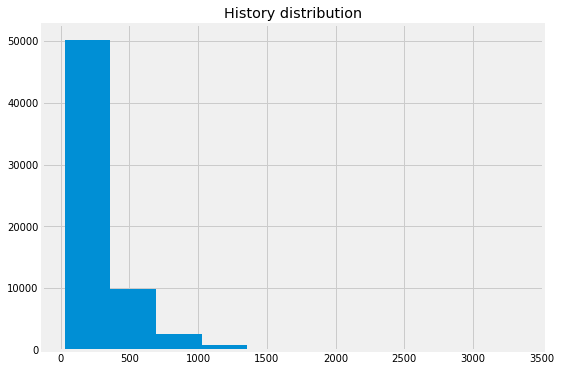

In [159]:
plt.figure(figsize=(8, 6))
plt.title('History distribution')
plt.hist(df['history'])
plt.show()

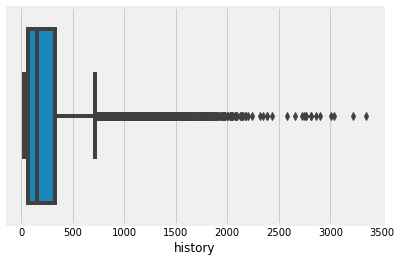

In [160]:
sns.boxplot(df['history'])

Заменим значения больше 2300 на медиану.

In [161]:
def clean_outlier(df, value=2300):
    
    df.loc[df['history'] > value, 'history'] = df['history'].median()
    
    return df

X_test = clean_outlier(X_test)
X_train = clean_outlier(X_train)

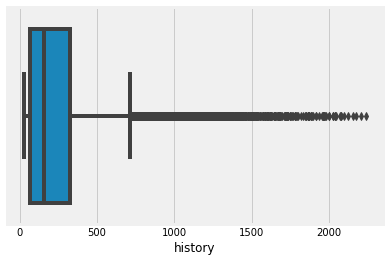

In [162]:
sns.boxplot(X_train['history'])

# 5
5. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями

In [163]:
df_results = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%'])
df_results

,model,uplift@10%,uplift@20%


## 1. одна модель с признаком коммуникации (S-learner)

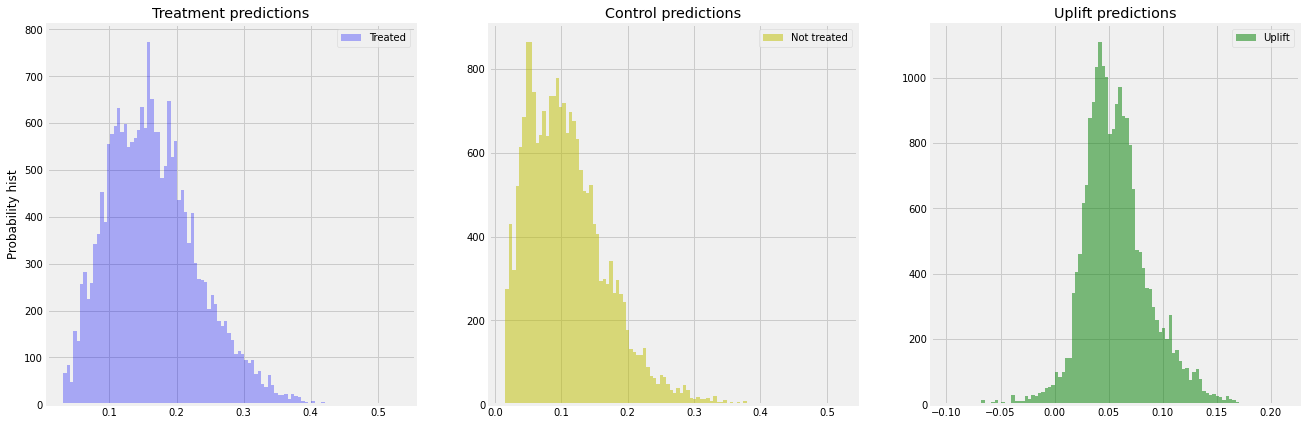

In [164]:
sm = SoloModel(CatBoostClassifier(iterations=100, random_state=42, silent=True, cat_features=cat_feature))

sm = sm.fit(X_train, y_train, treat_train)


uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)


df_results.loc[len(df_results.index)] = ['Solo Model', sm_score_10, sm_score_20]

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);  

## 2. модель с трансформацией таргета

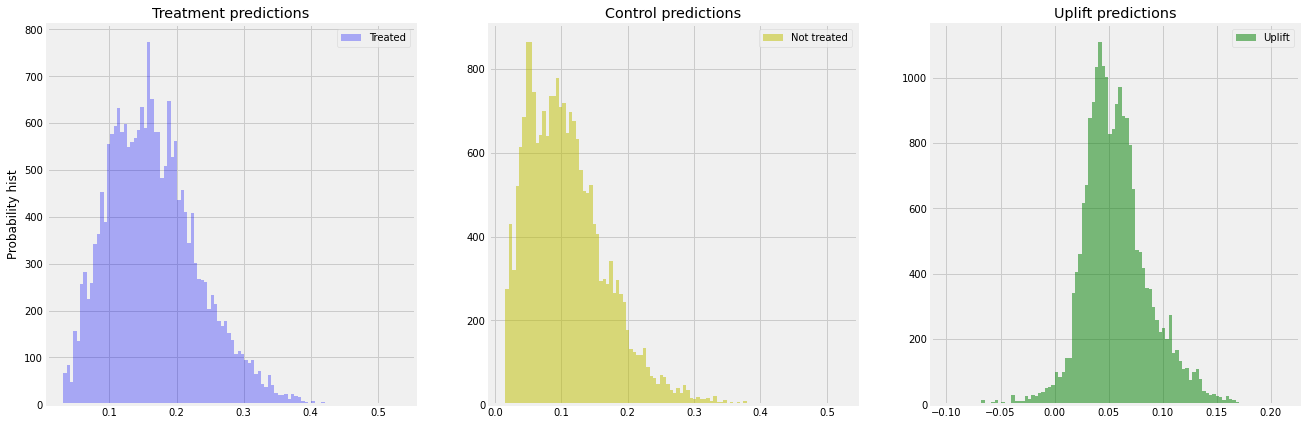

In [165]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

df_results.loc[len(df_results.index)] = ['Target', ct_score_10, ct_score_20]


# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

## 3. вариант с двумя независимыми моделями

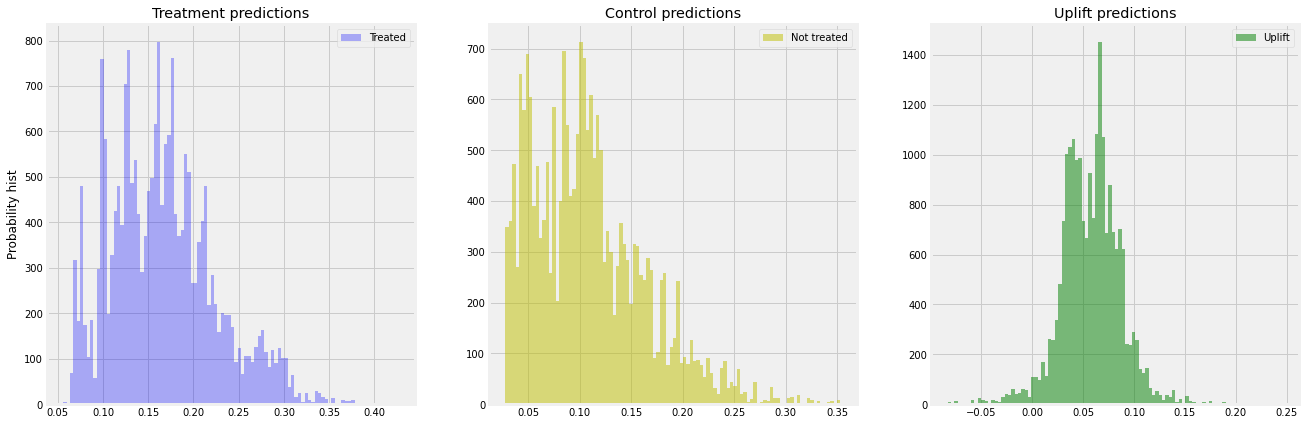

In [166]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

df_results.loc[len(df_results.index)] = ['Two models', tm_score_10, tm_score_20]

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

# 6
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [167]:
df_results

,model,uplift@10%,uplift@20%
0,Solo Model,0.100899,0.089732
1,Target,0.128311,0.114821
2,Two models,0.089599,0.092213


# 7
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [168]:
# X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df['target'], test_size = 0.33, random_state = 42)

In [169]:
# X_train.head()

In [170]:
X_train_tree = X_train.copy()
X_train_tree = pd.get_dummies(X_train_tree, columns=['zip_code', 'channel'])
X_train_tree.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
44233,10,29.99,1,0,0,0,0,1,0,0,1
58749,9,60.25,0,1,0,0,0,1,0,1,0
56296,8,292.30,1,1,1,0,0,1,0,0,1
23444,8,49.05,1,0,0,0,0,1,0,1,0
48936,12,324.32,1,0,0,0,0,1,0,0,1


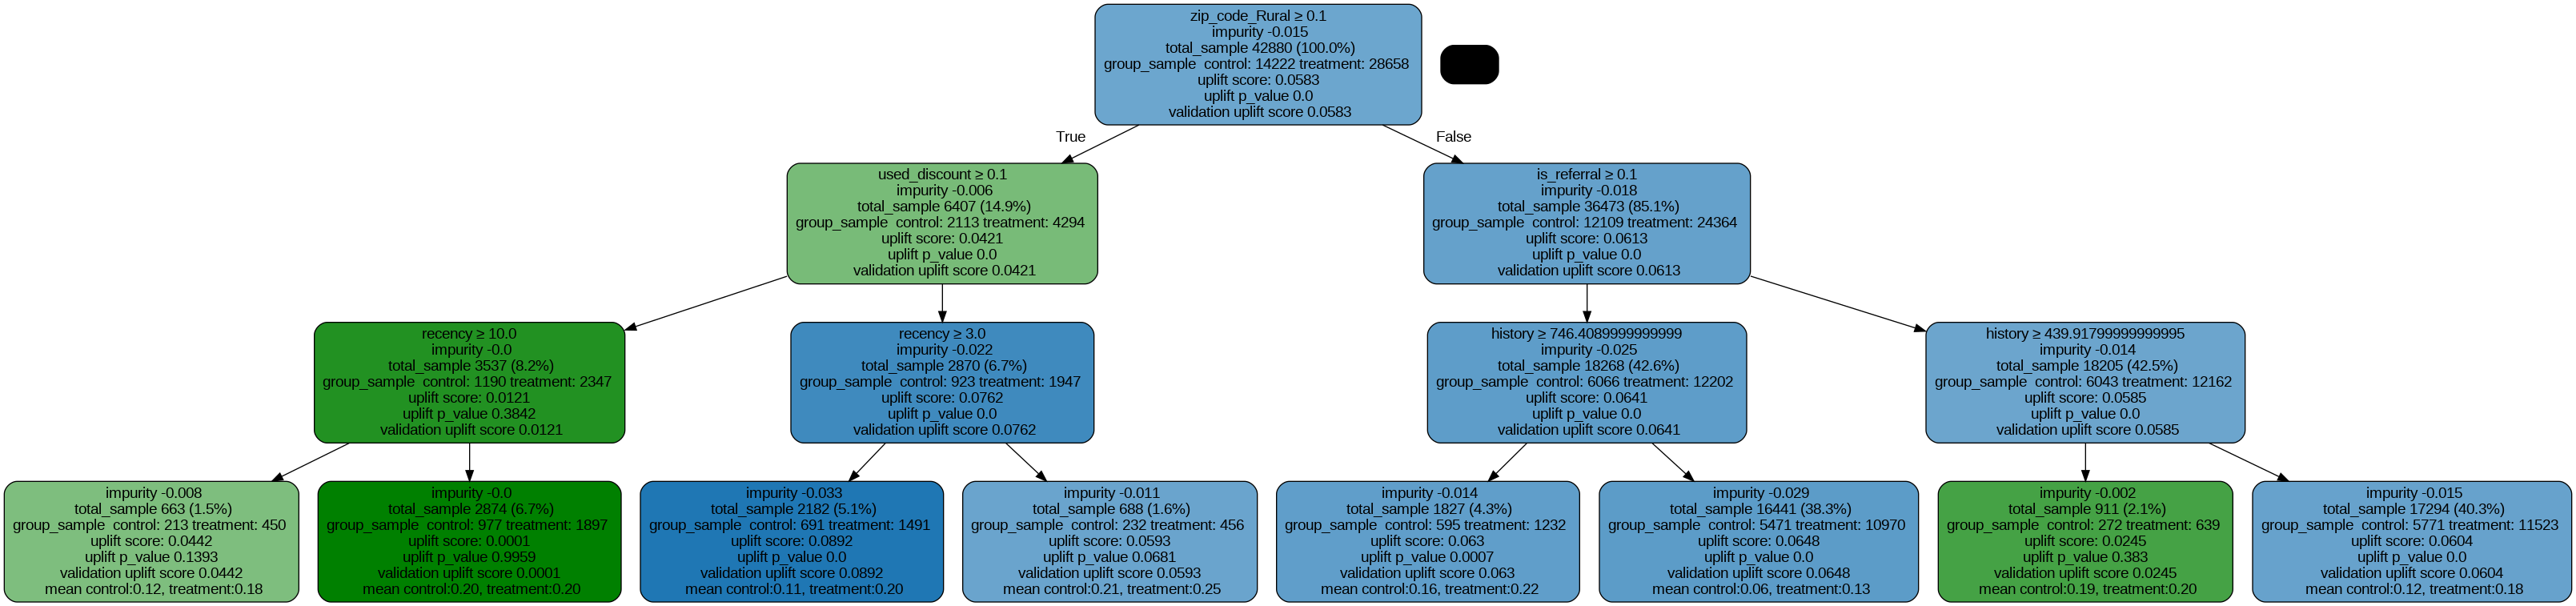

In [171]:
# Модель

features = [c for c in X_train_tree]

uplift_model = UpliftTreeClassifier(max_depth = 4,
                                    min_samples_leaf = 200,
                                    min_samples_treatment = 50,
                                    n_reg = 100,
                                    evaluationFunction = 'KL',
                                    control_name = 'control')

uplift_model.fit(X_train_tree.values,
                 treatment = treat_train.map({
                     1: 'treatment',
                     0: 'control'
                 }).values,
                 y = y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

In [172]:
uplift_model.feature_importances_

array([0.11404791, 0.25863635, 0.13132154, 0.        , 0.27791334,
       0.21808086, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

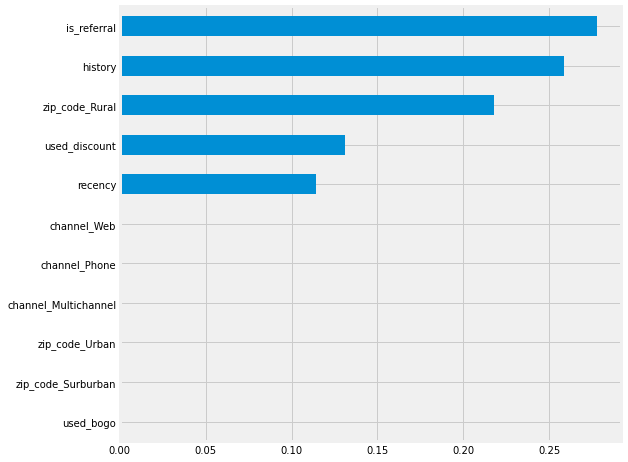

In [173]:
pd.Series(uplift_model.feature_importances_, index=features).sort_values().plot(kind='barh', figsize=(8,8))

Деревья глубиной 4. Наибольшее влияние на uplift_score оказали признаки: is_referral, history, zip_code_Rural, used_discount, recency.

# 8
8. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

In [174]:
sm = SoloModel(
    CatBoostClassifier(iterations=100, random_state=42, silent=True, cat_features=cat_feature)
)
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)

In [175]:
df_test = X_test.copy()
df_test['pred_uplift'] = uplift_sm
df_test['conversion'] = y_test
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
33042,9,64.85,1,0,Surburban,1,Web,0.030824,0
7209,1,144.12,0,1,Urban,0,Web,0.078325,0
24367,1,734.25,0,1,Surburban,1,Phone,0.082485,0
19599,4,1321.26,1,0,Surburban,1,Multichannel,0.086438,1
31465,2,261.23,1,1,Surburban,1,Web,0.170160,1


In [176]:
df_test = df_test.sort_values(by='pred_uplift', ascending=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
49150,8,229.270,1,1,Urban,1,Web,0.210871,0
31570,1,257.680,1,1,Surburban,1,Phone,0.207554,1
40937,12,31.980,0,1,Surburban,0,Web,0.197030,0
46493,1,158.115,1,1,Urban,1,Multichannel,0.194482,0
50233,1,158.115,1,1,Surburban,1,Phone,0.194152,0


In [177]:
df_test['deciles'] = pd.qcut(df_test['pred_uplift'], q=10, labels=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion,deciles
49150,8,229.270,1,1,Urban,1,Web,0.210871,0,9
31570,1,257.680,1,1,Surburban,1,Phone,0.207554,1,9
40937,12,31.980,0,1,Surburban,0,Web,0.197030,0,9
46493,1,158.115,1,1,Urban,1,Multichannel,0.194482,0,9
50233,1,158.115,1,1,Surburban,1,Phone,0.194152,0,9


In [178]:
for i in range(0, 10):
    tmp = df_test[df_test['deciles'] == i]
    print(f'Для дециля {i} средняя конверсия равна {tmp["conversion"].mean():.3f}')

Для дециля 0 средняя конверсия равна 0.160
Для дециля 1 средняя конверсия равна 0.123
Для дециля 2 средняя конверсия равна 0.112
Для дециля 3 средняя конверсия равна 0.139
Для дециля 4 средняя конверсия равна 0.130
Для дециля 5 средняя конверсия равна 0.144
Для дециля 6 средняя конверсия равна 0.151
Для дециля 7 средняя конверсия равна 0.152
Для дециля 8 средняя конверсия равна 0.161
Для дециля 9 средняя конверсия равна 0.188
